In [153]:
using HDF5, EzXML, Glob, Dates, Plots, JuMP, StatsBase, Symbolics, DataFrames, CSV, Random, Distributions, Printf, LinearAlgebra, StatsPlots, KernelDensity
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);
fid = 1
filename = files[fid]

filenames_trunc = Vector{String}()
for i = eachindex(files)
    push!(filenames_trunc, files[i][length(datapath)+1:end-5])
end

df = DataFrame(filename=filenames_trunc,
    Rcsf_icm=NaN, E_icm=NaN, Ib_icm=NaN, P0_icm=NaN,
    Rcsf_mode=NaN, E_mode=NaN, Ib_mode=NaN, P0_mode=NaN,
    Rcsf_mean=NaN, E_mean=NaN, Ib_mean=NaN, P0_mean=NaN,
    Rcsf_median=NaN, E_median=NaN, Ib_median=NaN, P0_median=NaN,
    Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN,
    Rcsf_prior_mean=NaN, E_prior_mean=NaN, P0_prior_mean=NaN,
    Rcsf_prior_std=NaN, E_prior_std=NaN, P0_prior_std=NaN,
    RMSE=NaN, R2=NaN, Pss=NaN,
    P_b=NaN, I_inf=NaN, P_p=NaN, inf_length=NaN, one_needle=NaN, Rn=NaN, rec_dur_s=NaN,
    inf_st=NaN, inf_en=NaN, plat_st=NaN, plat_en=NaN)

# 1.0 = only curve fitting, 0.0 = only PV curve fitting
alpha = 1.0
num_iter = 10^5
method = "standard"
means = [15.5, 0.18, 2.8]
stddevs = [10.36, 0.14, 10.54]

chain, chisave, Ib_chain = main(filename, num_iter, "informative", alpha, method, means, stddevs)
params_modes, params_means, params_stddevs = mean_and_stddev(chain)

if method == "standard"
    Rcsf = params_modes[1]
    E = params_modes[2]
    P_0 = params_modes[3]
    I_b = (Data["P_b"] - P_0) / Rcsf
    rmserr = calc_model_plot(I_b, E, P_0)[2]
elseif method == "Pss"
    Rcsf = params_modes[1]
    E = params_modes[2]
    Pss = params_modes[3]
    P_0 = Data["P_0"]
    I_b = (Data["P_b"] - Pss) / Rcsf
    rmserr = calc_model_plot(I_b, E, P_0, Pss)[2]
else
    Rcsf = params_modes[1]
    E = params_modes[2]
    P_0 = params_modes[3]
    Pss = params_modes[4]
    I_b = (Data["P_b"] - Pss) / Rcsf
    rmserr = calc_model_plot(I_b, E, P_0, Pss)[2]
end

df.P_b[fid] = Data["P_b"]
df.P_p[fid] = Data["P_p"]
df.inf_length[fid] = (Data["infusion_end_frame"] - Data["infusion_start_frame"]) # in frames
df.Rcsf_icm[fid] = Data["Rcsf"]
df.E_icm[fid] = Data["Rcsf"]
df.Ib_icm[fid] = Data["I_b"]
df.P0_icm[fid] = Data["P_0"]
df.I_inf[fid] = Data["I_inf"]
df.Rcsf_prior_mean[fid], df.E_prior_mean[fid],  df.P0_prior_mean[fid] = means
df.Rcsf_prior_std[fid], df.E_prior_std[fid],  df.P0_prior_std[fid] = stddevs
df.Rcsf_mode[fid], df.E_mode[fid],  df.P0_mode[fid] = params_modes
df.Rcsf_mean[fid], df.E_mean[fid],  df.P0_mean[fid] = params_means
df.Rcsf_std[fid], df.E_std[fid],  df.P0_std[fid] = params_stddevs
df.Ib_mean[fid] = mean(Ib_chain)
df.Ib_mode[fid] = StatsBase.mode(Ib_chain)
df.Ib_median[fid] = median(Ib_chain)
df.Ib_std[fid] = std(Ib_chain)
df.one_needle[fid] = Data["one_needle"]
df.Rn[fid] = Data["Rn"]
df.rec_dur_s[fid] = Data["rec_dur_s"]
df.RMSE[fid] = rmserr
df.R2[fid] = press_vol_curve(Rcsf, P_0, icp_inf)[4]
df.inf_st[fid]= Data["infusion_start_frame"]
df.inf_en[fid]= Data["infusion_end_frame"]
df.plat_st[fid] = Data["plateau_start"]
df.plat_en[fid] = Data["plateau_end"]

# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
CSV.write("/Users/jjc/Desktop/Results_BayesSTD.csv", df)



"/Users/jjc/Desktop/Results_BayesSTD.csv"

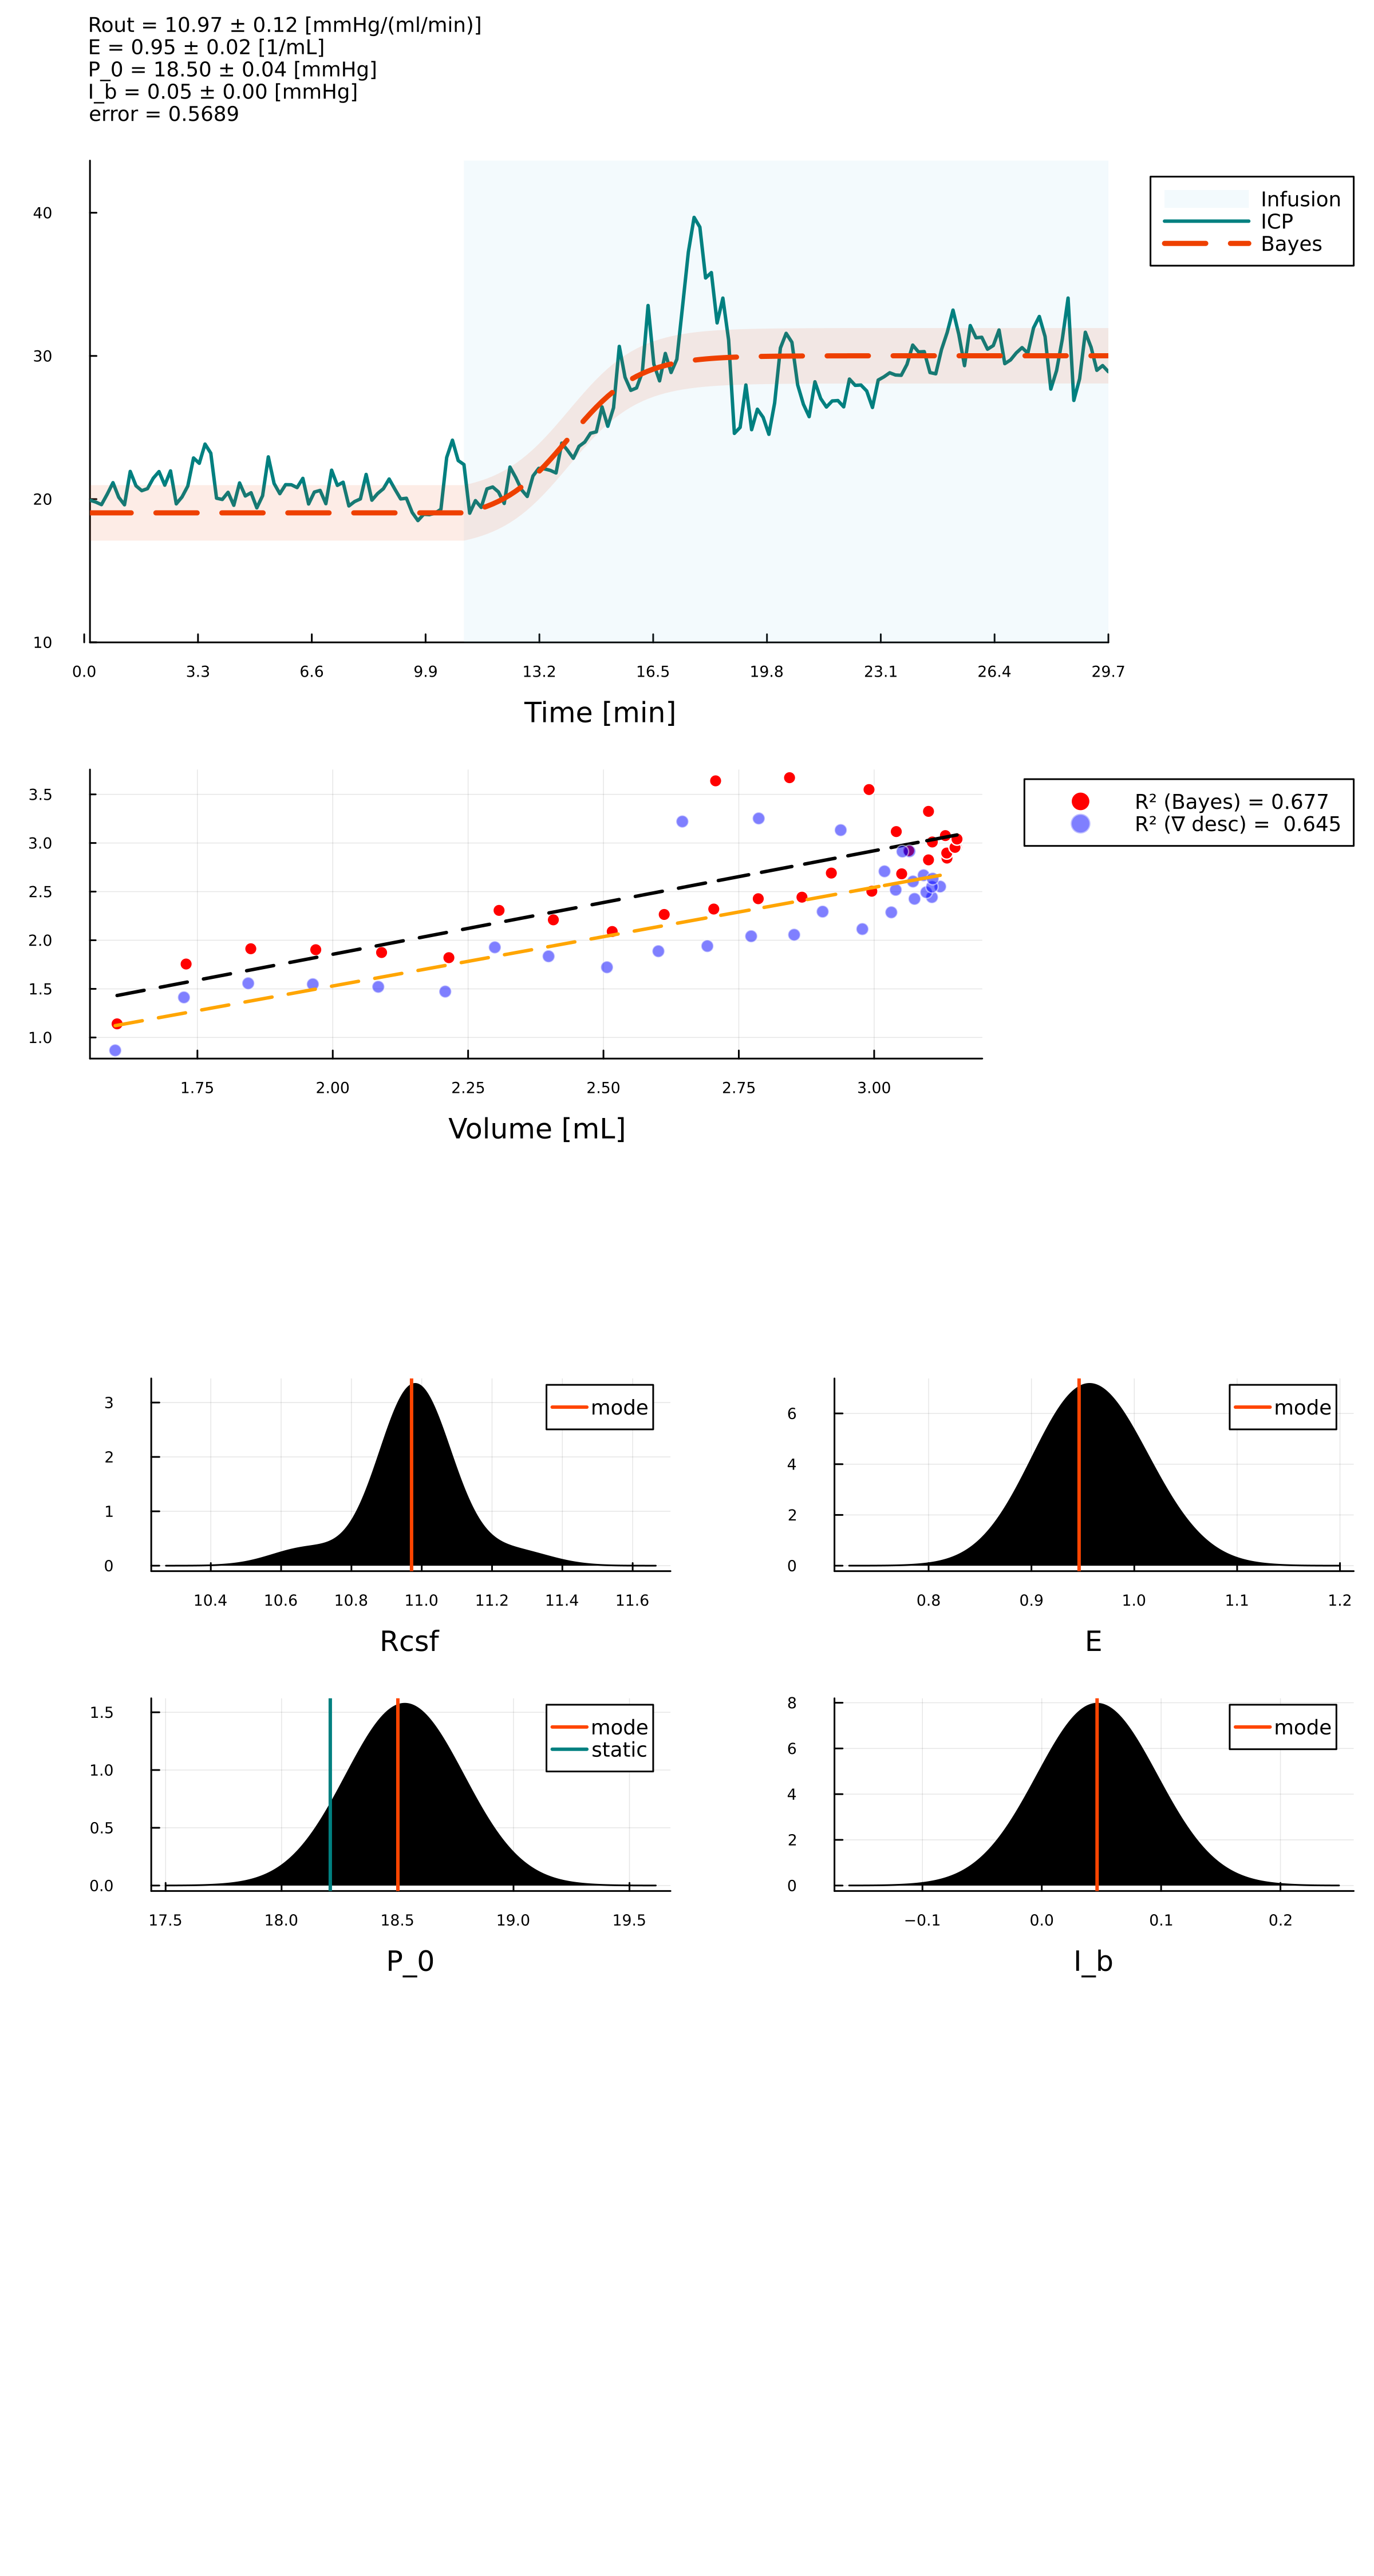

In [141]:
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

bayescol = :red
icmcol = :blue
bgcolor = :white

if method == "standard"
        h1 = plotmodel(I_b, E, P_0, params_means, params_stddevs, "dar", "")
        title!(@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_modes[1], params_stddevs[1]) *
               @sprintf("E = %0.2f ± %0.2f [1/mL]\n", params_modes[2], params_stddevs[2]) *
               @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", params_modes[3], params_stddevs[3]) *
               @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
               @sprintf("error = %0.4f \n", rmserr),
                titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0, icp_inf)
        h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label=@sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)
        plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1,
                label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")

elseif method == "Pss"
        h1 = plotmodel(I_b, E, P_0, Pss, params_means, params_stddevs, "dar", "")
        title!(@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_modes[1], params_stddevs[1]) *
               @sprintf("E = %0.2f ± %0.2f [1/mL]\n", params_modes[2], params_stddevs[2]) *
               @sprintf("Pss = %0.2f ± %0.2f [mmHg]\n", params_modes[3], params_stddevs[3]) *
               @sprintf("P_0 (static) = %0.2f [mmHg]\n", P_0) *
               @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
               @sprintf("error = %0.4f \n", rmserr),
                titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, Pss, icp_inf)
        h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label=@sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)
        plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1,
                label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
else
        h1 = plotmodel(I_b, E, P_0, Pss, params_means, params_stddevs, "dar", "")
        title!(@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_modes[1], params_stddevs[1]) *
               @sprintf("E = %0.2f ± %0.2f [1/mL]\n", params_modes[2], params_stddevs[2]) *
               @sprintf("Pss = %0.2f ± %0.2f [mmHg]\n", params_modes[4], params_stddevs[4]) *
               @sprintf("P_0 = %0.2f [mmHg]\n", P_0) *
               @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
               @sprintf("error = %0.4f \n", rmserr),
                titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, Pss, icp_inf)
        h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label=@sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)
        plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1,
                label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
        plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")

end

bw = 0.05

kernd = kde(chain[:, 1], bandwidth=bw * 2)
h3 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="")
vline!(h3, [params_modes[1]], lw=2, label="mode", linecolor=:orangered, xlabel="Rcsf", ylabel="\n\n")

kernd = kde(chain[:, 2], bandwidth=bw)
h4 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="")
vline!(h4, [params_modes[2]], lw=2, label="mode", linecolor=:orangered, xlabel="E", ylabel="\n\n")

kernd = kde(chain[:, 3], bandwidth=bw * 5)
h5 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="")
vline!(h5, [params_modes[3]], lw=2, label="mode", linecolor=:orangered, xlabel="P_0", ylabel="\n\n")
vline!(h5, [Data["P_0"]], lw=2, label="static", linecolor=:teal)

kernd = kde(Ib_chain, bandwidth=bw)
h6 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="")
smooth_dist = kde(Ib_chain, bandwidth=0.05) # Mode is unstable if there are very small differences between values - smoothen
smooth_dist_vals = collect(smooth_dist.x)
Ib_mode = smooth_dist_vals[findmax(kernd.density)[2]]
vline!(h6, [Ib_mode], lw=2, label="mode", linecolor=:orangered, xlabel="I_b", ylabel="\n\n")


plot(h1, h2, h3, h4, h5, h6, layout=[grid(2, 1, heights=[0.5, 0.3]), grid(2, 2, heights=[0.2, 0.2, 0.2, 0.2])], size=(800, 1500), dpi=300, tickfontsize=6)

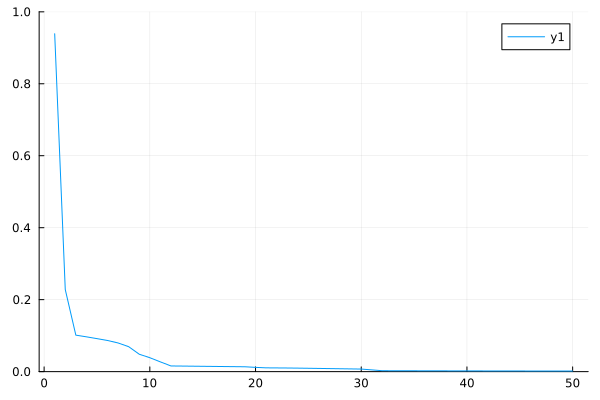

In [67]:
sz = Int64(length(chisave)/20)
acr = collect(1:100:sz)

plot(autocor(chisave[1:end], acr), ylims=[0,1], seriestype=:line)


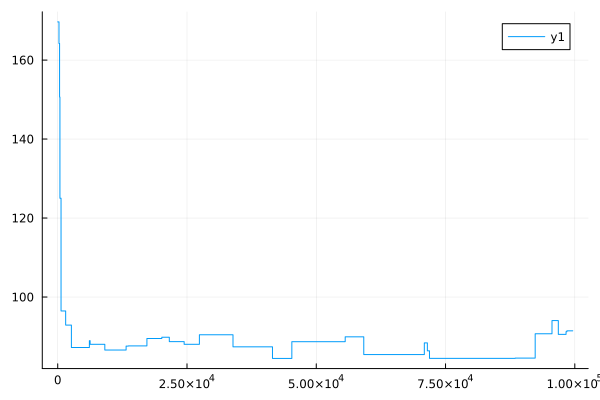

In [68]:
plot(chisave[400:end])